In [130]:
import pandas as pd
import numpy as np
import nltk
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [131]:
data=pd.read_csv("/kaggle/input/newdatas/test.csv",nrows=100000)

In [132]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [133]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [134]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [135]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [136]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')


In [137]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: ever noticed plane seats appear getting smaller smaller increasing numbers people taking skies experts questioning packed planes putting passengers risk say shrinking space aeroplanes uncomfortable putting health safety danger squabbling arm rest shrinking space planes putting health safety danger week consumer advisory group set department transportation said public hearing government happy set standards animals flying planes stipulate minimum amount space humans world animals rights space food humans said charlie leocha consumer representative committee time dot faa take stand humane treatment passengers could crowding planes lead serious issues fighting space overhead lockers crashing elbows seat back kicking tests conducted faa use planes inch pitch standard airlines decreased many economy seats united airlines inches room airlines offer little inches cynthia corbertt human factors researcher federal aviation administration conducts tests quickly passengers leave plane test

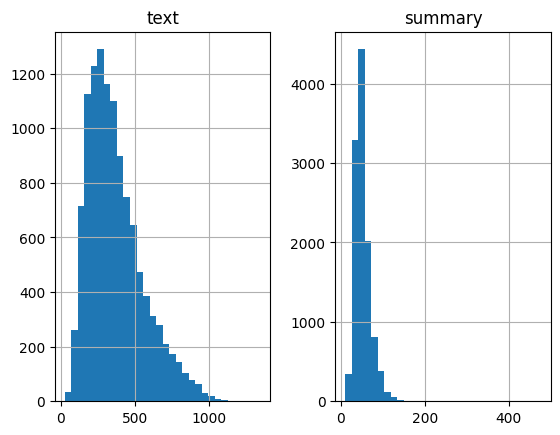

In [138]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [139]:
max_len_text=80
max_len_summary=10

In [140]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 


In [141]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [142]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [151]:
from keras import backend as K
from keras.layers import Input, Embedding, LSTM, Concatenate, TimeDistributed, Dense, Dropout, Bidirectional
from keras.models import Model

# Clear the session
K.clear_session()

# Parameters
latent_dim = 500
embedding_dim = 300  # Adjusted embedding dimension
dropout_rate = 0.3

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, embedding_dim, trainable=True)(encoder_inputs)

# Bidirectional LSTM with Dropout
encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)
state_h1 = Concatenate()([forward_h1, backward_h1])
state_c1 = Concatenate()([forward_c1, backward_c1])

encoder_lstm2 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_output1)
state_h2 = Concatenate()([forward_h2, backward_h2])
state_c2 = Concatenate()([forward_c2, backward_c2])

encoder_lstm3 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))
encoder_outputs, forward_h3, forward_c3, backward_h3, backward_c3 = encoder_lstm3(encoder_output2)
state_h = Concatenate()([forward_h3, backward_h3])
state_c = Concatenate()([forward_c3, backward_c3])

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Add more LSTM layers in the decoder
decoder_lstm1 = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_output1, _, _ = decoder_lstm1(dec_emb, initial_state=[state_h, state_c])

decoder_lstm2 = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_outputs, _, _ = decoder_lstm2(decoder_output1)

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

# Compile the model with a custom learning rate
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 300)   │ 24,862,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 80,       │  3,204,000 │ embedding[0][0]   │
│ (Bidirectional)     │ 1000), (None,     │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ [(None, 80,       │  6,004,000 │ bidirectional[0]… │
│ (Bidirectional)     │ 1000), (None,     │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ [(None, 80,       │  6,004,000 │ bidirectional_1[… │
│ (Bidirectional)     │ 1000), (None,     │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 300) │  9,579,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 1000)      │          0 │ bidirectional_2[… │
│ (Concatenate)       │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1000)      │          0 │ bidirectional_2[… │
│ (Concatenate)       │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │  5,204,000 │ embedding_1[0][0… │
│                     │ 1000), (None,     │            │ concatenate_4[0]… │
│                     │ 1000), (None,     │            │ concatenate_5[0]… │
│                     │ 1000)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, None,     │  8,004,000 │ lstm_3[0][0]      │
│                     │ 1000), (None,     │            │                   │
│                     │ 1000), (None,     │            │                   │
│                     │ 1000)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 128,759,332 (491.18 MB)

 Trainable params: 128,759,332 (491.18 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [150]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 170s 955ms/step - accuracy: 0.1206 - loss: 7.6334 - val_accuracy: 0.1498 - val_loss: 6.6183
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 152s 940ms/step - accuracy: 0.1517 - loss: 6.4733 - val_accuracy: 0.1675 - val_loss: 6.4799
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 152s 939ms/step - accuracy: 0.1722 - loss: 6.2130 - val_accuracy: 0.1861 - val_loss: 6.3465
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 152s 941ms/step - accuracy: 0.1901 - loss: 5.9240 - val_accuracy: 0.1995 - val_loss: 6.2533
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 152s 938ms/step - accuracy: 0.2042 - loss: 5.6031 - val_accuracy: 0.2031 - val_loss: 6.2181


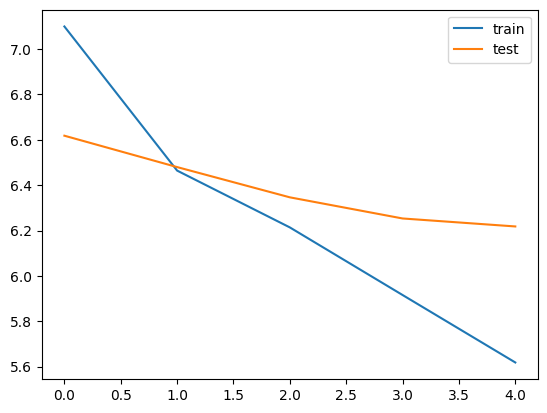

In [152]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [153]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [154]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [155]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [156]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [157]:
# Update decoder's LSTM layers to use latent_dim * 2
decoder_lstm1 = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_output1, _, _ = decoder_lstm1(dec_emb, initial_state=[state_h, state_c])

decoder_lstm2 = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_outputs, _, _ = decoder_lstm2(decoder_output1)

# Ensure the input shape to the decoder model matches the expectations
# Update the final decoder model creation if necessary
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)



In [158]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Choose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if (sampled_token != 'end'):
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [159]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from keras import backend as K

# Assuming you have defined the following variables:
# max_len_text, max_len_summary, latent_dim, dropout_rate, 
# x_tokenizer, y_tokenizer, and the embedding layer (dec_emb_layer)

# Reverse token mappings
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

# Encoder Model
encoder_inputs = Input(shape=(max_len_text,))
encoder_embedding = Embedding(input_dim=len(x_tokenizer.word_index) + 1, output_dim=500)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder Model
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(input_dim=len(y_tokenizer.word_index) + 1, output_dim=500)
dec_emb = dec_emb_layer(decoder_inputs)

# Updated decoder's state input shapes for bidirectional LSTM
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# LSTM for decoding
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_outputs, state_h2, state_c2 = decoder_lstm(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention Layer (Ensure this is correctly defined)
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs, attn_out_inf])

# Dense layer for output
decoder_dense = Dense(len(y_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Choose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        # Predict with updated shapes
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out] + [e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if (sampled_token != 'end'):
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0 and i != target_word_index['start']) and i != target_word_index['end']:
            newString += reverse_target_word_index[i] + ' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0):
            newString += reverse_source_word_index[i] + ' '
    return newString


In [161]:
from rouge_score import rouge_scorer
import numpy as np

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Store the ROUGE scores for each sample
rouge_scores = {
    'rouge1': [],
    'rouge2': [],
    'rougeL': []
}

# Iterate through each sample in the validation set
for i in range(len(x_val)):
    # Original review and summary
    input_seq = x_val[i].reshape(1, max_len_text)
    actual_summary = seq2summary(y_val[i])

    # Predicted summary using your decode_sequence function
    predicted_summary = decode_sequence(input_seq)

    # Calculate ROUGE scores for this sample
    scores = scorer.score(actual_summary, predicted_summary)
    rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
    rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
    rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores across all samples
average_rouge1 = np.mean(rouge_scores['rouge1'])
average_rouge2 = np.mean(rouge_scores['rouge2'])
average_rougeL = np.mean(rouge_scores['rougeL'])

# Print the results
print(f'Average ROUGE-1: {average_rouge1:.4f}')
print(f'Average ROUGE-2: {average_rouge2:.4f}')
print(f'Average ROUGE-L: {average_rougeL:.4f}')



Average ROUGE-1: 0.0395
Average ROUGE-2: 0.0120
Average ROUGE-L: 0.0387
